In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, random_state=1)
y = np.where(y ==0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

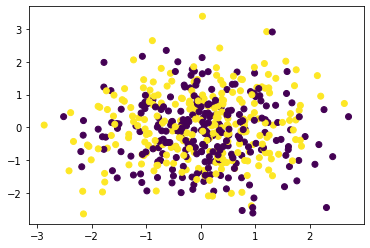

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### adding some very small value to the lower term

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

m = X_train.shape[0]
S = 20
stump_params = {'max_depth': 1, 'max_leaf_nodes': 2}
models = [DecisionTreeClassifier(**stump_params) for _ in range(S)]

W = np.full(m, 1/m)

a_js = np.zeros(S)

for j, model in enumerate(models):
    
    
    model.fit(X_train, y_train, sample_weight = W)
    
    yhat = model.predict(X_train)
    err = W[(yhat !=y_train)].sum()
    
    # if err=0, then alpha will be undefined, prevet by adding small value to the lower term
    a_j = np.log ((1 - err) / (err + 0.00001)) * 0.5
    a_js[j] = a_j
    
    W = (W * np.exp(-a_j * y_train * yhat))
    W = W / sum (W)
    
Hx = 0
for i, model in enumerate(models):
    yhat = model.predict(X_test)
    Hx += a_js[i] * yhat

yhat = np.sign(Hx)


print(classification_report(y_test, yhat))
print('Ada score: ', accuracy_score(y_test, yhat))

              precision    recall  f1-score   support

          -1       0.96      0.97      0.97        79
           1       0.97      0.96      0.96        71

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

Ada score:  0.9666666666666667


### adding paramter called eta

In [5]:
m = X_train.shape[0]
S = 20
stump_params = {'max_depth':1, 'max_leaf_nodes':2}
models = [DecisionTreeClassifier(**stump_params) for _ in range(S)]

eta_list = [0.25, 0.5, 0.75, 1]

a_js = np.zeros((len(eta_list), S))

for i in range(len(eta_list)):
    
    W = np.full(m, 1/m)
    
    for j, model in enumerate(models):
        
        model.fit(X_train, y_train, sample_weight = W)
        
        yhat = model.predict(X_train)
        err = W[(yhat != y_train)].sum()
        
        a_j = np.log ((1 - err)/(err + 0.00001)) * eta_list[i]
        a_js[i,j] = a_j
        
        W = (W * np.exp(-a_j * y_train * yhat))
        W = W / sum (W)

    Hx = 0
    for j, model in enumerate(models):
        yhat = model.predict(X_test)
        Hx += a_js[i, j] * yhat
    yhat = np.sign(Hx)
    print("eta :", eta_list[i])
    print(classification_report(y_test, yhat))
    print(f"Ada score with eta {eta_list[i]}: ", accuracy_score(y_test, yhat))
    print('='*30)
    print('='*30)

eta : 0.25
              precision    recall  f1-score   support

          -1       0.94      0.95      0.94        79
           1       0.94      0.93      0.94        71

    accuracy                           0.94       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.94      0.94      0.94       150

Ada score with eta 0.25:  0.94
eta : 0.5
              precision    recall  f1-score   support

          -1       0.96      0.97      0.97        79
           1       0.97      0.96      0.96        71

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

Ada score with eta 0.5:  0.9666666666666667
eta : 0.75
              precision    recall  f1-score   support

          -1       0.95      0.96      0.96        79
           1       0.96      0.94      0.95        71

    accuracy                           0.95       150
   macro avg       0.

### Task 3 and 4

In [6]:
class DecisionStump():
    
    def __init__(self):
        
        self.polarity = 1
        self.feature_index = None
        self.threshold = None
        self.alpha = None
        
class AdaBoost():
    
    def __init__(self, S=5, eta=0.5):
        self.S = S
        self.eta = eta
        
    def fit(self, X, y):
        
        m, n = X.shape
        W = np.full(m, 1/m)
        self.clfs = []
        
        for _ in range(self.S):
            clf = DecisionStump()
            
            min_err = np.inf
            
            for feature in range(n):
                feature_vals = np.sort(np.unique(X[:, feature]))
                thresholds = (feature_vals[:-1] + feature_vals[1:])/2
                for threshold in thresholds:
                    for polarity in [1, -1]:
                        yhat = np.ones(len(y))
                        yhat[polarity * X[:, feature] < polarity * threshold] = -1
                        err = W[(yhat !=y)].sum()
                        
                        if err < min_err:
                            clf.polarity = polarity
                            clf.threshold = threshold
                            clf.feature_index = feature
                            min_err = err
            eps = 1e-10
            clf.alpha = self.eta * (np.log((1 - min_err)/(min_err + eps)))
            W = W * np.exp(-clf.alpha * y * yhat)
            W = W /sum(W)
            self.clfs.append(clf)

    def predict(self,X):
        m,n = X.shape
        yhat = np.zeros(m)
        for clf in self.clfs:
            pred = np.ones(m)
            pred[clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold] = -1
            yhat += clf.alpha * pred
        return np.sign(yhat)

In [7]:
model = AdaBoost(S=10)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

          -1       0.72      0.99      0.83        79
           1       0.98      0.56      0.71        71

    accuracy                           0.79       150
   macro avg       0.85      0.78      0.77       150
weighted avg       0.84      0.79      0.78       150



In [8]:
model = AdaBoost(S=20)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

          -1       0.72      0.99      0.83        79
           1       0.98      0.56      0.71        71

    accuracy                           0.79       150
   macro avg       0.85      0.78      0.77       150
weighted avg       0.84      0.79      0.78       150

